## Assignment 5 : 
Perform LSTM Price Movement Predictions For Trading Algorithms. How does that differ to the approaches seen today?

In [76]:
python_material_folder_name = "python-material"

In [77]:
import matplotlib.pyplot as plt
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Check if in Google Colab environment
try:
    from google.colab import drive
    # Mount drive
    drive.mount('/content/drive')
    # Set up path to Python material parent folder
    path_python_material = rf"drive/MyDrive/{python_material_folder_name}"
        # If unsure, print current directory path by executing the following in a new cell:
        # !pwd
    IN_COLAB = True
except:
    IN_COLAB = False
    # If working locally on Jupyter Notebook, parent folder is one folder up (assuming you are using the folder structure shared at the beginning of the course)
    path_python_material = ".."

# **LSTM Price Movement Prediction for Trading Algorithms**

## **1. Introduction**
This notebook demonstrates how to use an LSTM (Long Short-Term Memory) model for predicting stock price movements based on historical data. The steps include:
- Loading and preparing the data.
- Building and training an LSTM model.
- Evaluating performance using appropriate metrics (e.g., RMSE).
- Comparing the LSTM approach with traditional time series models like ARIMA and Prophet.
- Discussing the implications for trading strategies.

---

## **2. Data Preparation**
We load historical stock data using the `yfinance` library. This section also calculates technical indicators such as RSI and Moving Averages to enhance feature engineering.

### **Steps in Data Preparation**
1. Load the dataset.
2. Handle missing values.
3. Normalize the data.
4. Create sequences for LSTM.



In [79]:
!pip install yfinance

import yfinance as yf
# Define the ticker symbol for Apple Inc.
chosen_stock = 'AAPL'

# Use yfinance to download the stock data
stock_data = yf.download(chosen_stock, start='2015-01-01', end='2025-03-06', interval='1d')

# Display the first few rows of the data
stock_data.tail()

[*********************100%***********************]  1 of 1 completed

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-02-27,237.300003,242.460007,237.059998,239.410004,41153600
2025-02-28,241.839996,242.089996,230.199997,236.949997,56833400
2025-03-03,238.029999,244.029999,236.110001,241.789993,47184000
2025-03-04,235.929993,240.070007,234.679993,237.710007,53798100
2025-03-05,235.740005,236.550003,229.229996,235.419998,47227600


In [80]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import yfinance as yf

# Step 1: Data Fetching and Preprocessing
chosen_stock = 'AAPL'

# Download the stock data
stock_data = yf.download(chosen_stock, start='2015-01-01', end='2025-03-06', interval='1d')

# Calculate RSI (Relative Strength Index)
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

stock_data['RSI'] = calculate_rsi(stock_data['Close'], window=14)

# Calculate Moving Average
stock_data['Moving_Average'] = stock_data['Close'].rolling(window=14).mean()

# Drop NaN values from indicators
stock_data = stock_data.dropna()

# Normalize only the Close feature separately for inverse transformation
close_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = close_scaler.fit_transform(stock_data[['Close']])

# Combine all features (Close, RSI, Moving_Average) for LSTM input
scaler = MinMaxScaler(feature_range=(0, 1))
features = stock_data[['Close', 'RSI', 'Moving_Average']].values
scaled_features = scaler.fit_transform(features)



[*********************100%***********************]  1 of 1 completed


## LSTM Model Implementation
We implement an LSTM model following the YouTube example, with one LSTM layer and one Dense layer.

## Steps in Model Implementation
- Create input sequences for LSTM.
- Define and compile the LSTM model.
- Train the model.

In [82]:
# Step 2: Create Input Sequences for LSTM
sequence_length = 30  # Number of time steps
X, y = [], []
for i in range(len(scaled_close) - sequence_length):
    X.append(scaled_features[i:i+sequence_length])  # Input features
    y.append(scaled_close[i+sequence_length])  # Target is the 'Close' price

X = np.array(X)
y = np.array(y)

# Split data into training and testing sets
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Step 3: Build and Compile the LSTM Model
model = Sequential()
model.add(LSTM(64, return_sequences=False, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(1))  # Dense output layer for price prediction
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the Model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)


Epoch 1/50


C:\Users\acban\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0141 
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.4267e-04 
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7316e-04 
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5056e-04 
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.5813e-04 
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3400e-04 
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5700e-04 
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2889e-04 
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2742e-04 
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2242e-04 
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4010e-04 
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1467e-04 
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1373e-04 
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1677e-04 
Epoch 15/50
63/63 ━━━━━━━━━━━━

## Performance Evaluation
We evaluate the performance of the LSTM model using RMSE and compare actual vs. predicted prices.

## Steps in Performance Evaluation
- Predict prices for the test set.
- Inverse transform predictions and actual prices.
- Calculate RMSE.
- Plot actual vs. predicted prices.

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 


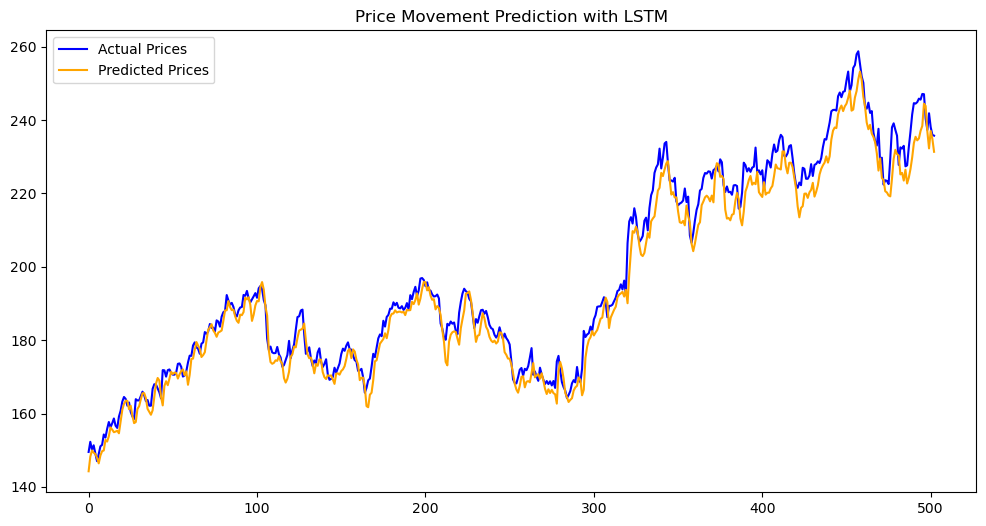

In [84]:
# Step 4: Evaluate Model and Visualize Results
predicted_prices = model.predict(X_test)
predicted_prices_inverse = close_scaler.inverse_transform(predicted_prices.reshape(-1, 1))
y_test_inverse = close_scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Prices', color='blue')
plt.plot(predicted_prices_inverse, label='Predicted Prices', color='orange')
plt.legend()
plt.title('Price Movement Prediction with LSTM')
plt.show()


In [85]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Compute RMSE for LSTM predictions
rmse = np.sqrt(mean_squared_error(y_test_inverse, predicted_prices_inverse))
print(f'Root Mean Squared Error (RMSE): {rmse}')


Root Mean Squared Error (RMSE): 4.755995267292261


## Comparison to Traditional Methods
## Key Differences
### ARIMA:
- Relies on stationarity assumptions.
- Handles linear trends well but struggles with non-linear dependencies.

### Prophet:
- Excels at capturing seasonality and trends.
- Limited to additive models and simpler relationships.

### LSTM:
- Captures complex non-linear and sequential patterns.
- Requires more data and computational power but produces better accuracy for time series with intricate dependencies.

## Business/Trading Insights
## Implications for Trading Algorithms

### Strengths:
- LSTMs can detect subtle patterns in stock price movements, making them highly valuable for trading strategies.
- Incorporating technical indicators like RSI and Moving Averages improves prediction accuracy.

### Weaknesses:
- LSTMs are prone to overfitting and require significant data preprocessing and hyperparameter tuning.
- Predictions may lag in real-time scenarios due to computational complexity.